In [1]:
import math
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd
import seaborn as sb

np.random.seed(0)
%matplotlib inline

In [2]:
def load(path):
    data = pd.read_csv(path)
    print('Data points: {}'.format(data.shape[0]))
    return data

train_data = load('data/train.csv')
test_data = load('data/test.csv')

train_data.head()

Data points: 891
Data points: 418


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def round(value, precision=10000):
    return math.ceil(value * precision) / precision

def summarize(data):
    for column in data.columns:
        print('{}: {} unique, {} missing'.format(
            column, data[column].unique().size, data[column].isnull().sum()))

def correlate(data, limit=10):
    for column in data.columns:
        correlation = None
        if pd.api.types.is_numeric_dtype(data[column]):
            correlation = round(data[column].corr(data['Survived']))
        elif data[column].unique().size < limit:
            dummies = pd.get_dummies(data[column])
            correlation = [dummies[column].corr(data['Survived']) for column in dummies.columns]
            correlation = [round(value) for value in correlation]
        print('{}: {} correlation'.format(column, correlation))

summarize(train_data)
print()
summarize(test_data)
print()
correlate(train_data)

PassengerId: 891 unique, 0 missing
Survived: 2 unique, 0 missing
Pclass: 3 unique, 0 missing
Name: 891 unique, 0 missing
Sex: 2 unique, 0 missing
Age: 89 unique, 177 missing
SibSp: 7 unique, 0 missing
Parch: 7 unique, 0 missing
Ticket: 681 unique, 0 missing
Fare: 248 unique, 0 missing
Cabin: 148 unique, 687 missing
Embarked: 4 unique, 2 missing

PassengerId: 418 unique, 0 missing
Pclass: 3 unique, 0 missing
Name: 418 unique, 0 missing
Sex: 2 unique, 0 missing
Age: 80 unique, 86 missing
SibSp: 7 unique, 0 missing
Parch: 8 unique, 0 missing
Ticket: 363 unique, 0 missing
Fare: 170 unique, 1 missing
Cabin: 77 unique, 327 missing
Embarked: 3 unique, 0 missing

PassengerId: -0.005 correlation
Survived: 1.0 correlation
Pclass: -0.3384 correlation
Name: None correlation
Sex: [0.5434, -0.5433] correlation
Age: -0.0772 correlation
SibSp: -0.0353 correlation
Parch: 0.0817 correlation
Ticket: None correlation
Fare: 0.2574 correlation
Cabin: None correlation
Embarked: [0.1683, 0.0037, -0.1556] corr

In [4]:
def compose_person(data):
    age, sex = data
    return 'Child' if age < 16 else sex.capitalize()

def compose_class(data):
    data = data[0]
    if data == 1: return 'Upper'
    elif data == 2: return 'Middle'
    elif data == 3: return 'Lower'
    raise 'Unknown class'

def denan(data, column):
    mean = data[column].mean()
    deviation = data[column].std()
    count = data[column].isnull().sum()
    rand = np.random.randint(mean - deviation, mean + deviation, size=count)
    data.loc[np.isnan(data[column]), column] = rand
    return count

def prepare(data, columns=['PassengerId', 'Survived', 'Age', 'Person', 'Class']):
    denan(data, 'Age')
    data['Age'] = data['Age'].astype(int)
    data['Person'] = data[['Age', 'Sex']].apply(compose_person, axis=1)
    data['Class'] = data[['Pclass']].apply(compose_class, axis=1)
    data.drop(list(set(data.columns.values) - set(columns)), axis=1, inplace=True)

prepare(train_data)
prepare(test_data)

train_data.head()

,PassengerId,Survived,Age,Person,Class
0,1,0,22,Male,Lower
1,2,1,38,Female,Upper
2,3,1,26,Female,Lower
3,4,1,35,Female,Upper
4,5,0,35,Male,Lower


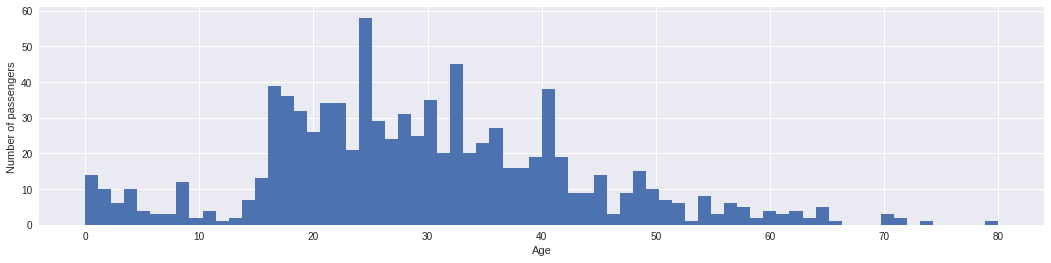

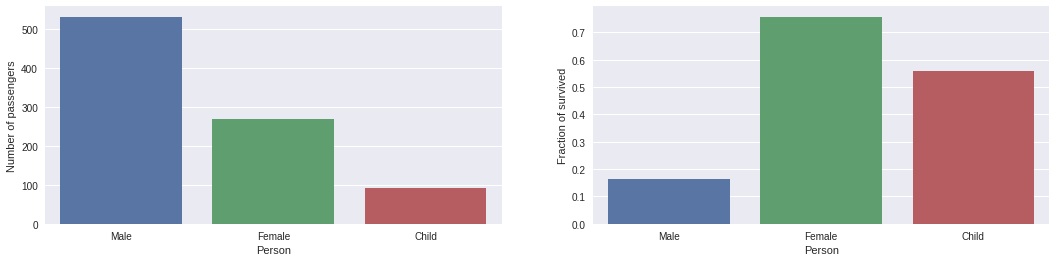

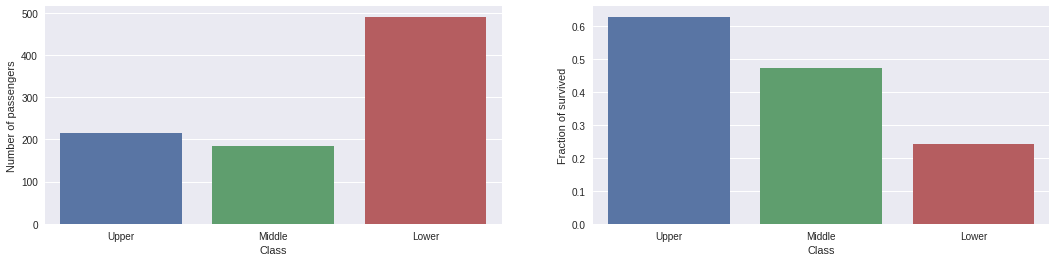

In [5]:
def plot_histogram(data, column):
    figure = pp.figure(figsize=(18, 4))
    data[column].hist(bins=70)
    pp.xlabel(column)
    pp.ylabel('Number of passengers')

def plot_survived(data, column, order):
    figure, axes = pp.subplots(1, 2, figsize=(18, 4))
    sb.countplot(x=column, data=data, ax=axes[0], order=order)
    data = data[[column, 'Survived']].groupby([column], as_index=False).mean()
    sb.barplot(x=column, y='Survived', data=data, ax=axes[1], order=order)
    axes[0].set_ylabel('Number of passengers')
    axes[1].set_ylabel('Fraction of survived')

plot_histogram(train_data, 'Age')
plot_survived(train_data, 'Person', ['Male', 'Female', 'Child'])
plot_survived(train_data, 'Class', ['Upper', 'Middle', 'Lower'])

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
def make_dummies(data, mapping):
    for column in mapping:
        dummies = pd.get_dummies(data[column])
        dummies.columns = mapping[column]
        data = data.join(dummies)
    data.drop(mapping.keys(), inplace=True, axis=1)
    return data

mapping = {
    'Person': ['Male', 'Female', 'Child'],
    'Class': ['Upper', 'Middle', 'Lower'],
}

train_data = make_dummies(train_data, mapping)
test_data = make_dummies(test_data, mapping)

train_data.head()

,PassengerId,Survived,Age,Male,Female,Child,Upper,Middle,Lower
0,1,0,22,0,0,1,1,0,0
1,2,1,38,0,1,0,0,0,1
2,3,1,26,0,1,0,1,0,0
3,4,1,35,0,1,0,0,0,1
4,5,0,35,0,0,1,1,0,0


In [8]:
X_train = train_data.drop(['PassengerId', 'Survived'], axis=1)
Y_train = train_data['Survived']
X_test = test_data.drop('PassengerId', axis=1)

In [9]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train)
print('Score: {}'.format(model.score(X_train, Y_train)))

Score: 0.8653198653198653


In [10]:
data = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': model.predict(X_test),
})
data.to_csv('Solution.csv', index=False)